In [19]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

import sigkernel as ksig_pde
import sigkernel_ as ksig_disc
import utils.data
from generators.generators import *
from generators.ESN import ESNGenerator
from models.trainer_ESN_MMD import train_ESN_MMD
from sigkernel_.loss import compute_mmd_loss
from utils.analyse_results import plot_loss_from_run, inspect_run_and_mmd

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype=torch.float64

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Kernels

In [20]:
# Define the discretized signature kernel
static_kernel_type    = 'rbf' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels              = 10 # number of levels in the truncated signature kernel
disc_sig_kernel_sigma = 1e-5 # bandwidth parameter for the static kernel

kwargs_disc_sig = {
    'static_kernel_type': static_kernel_type,
    'n_levels': n_levels,
    'kernel_sigma': disc_sig_kernel_sigma,
}

sig_disc_kernel = ksig_disc.kernels.get_discretized_signature_kernel(**kwargs_disc_sig)

#---------------------------------
# Define the pde signature kernel
pde_sig_sigma = 1e1 # bandwidth parameter for the static kernel
static_kernel = ksig_pde.RBFKernel(sigma=pde_sig_sigma) # define static kernel

# Initialize the corresponding signature kernel
sig_pde_kernel = ksig_pde.SigKernel(static_kernel, dyadic_order=0)

#---------------------------------
# Define static kernel
static_sigma = 1e3 # bandwidth parameter for the static kernel
rbf_kernel = ksig_disc.kernels.RBFKernel(sigma=static_sigma)

### Choose which kernel

In [21]:
# choose one:
# kernel = sig_disc_kernel      # discretized signature kernel
kernel = sig_pde_kernel        # pde signature kernel
# kernel = rbf_kernel           # static kernel

if "sig" in kernel.__class__.__name__.lower() or "volt" in kernel.__class__.__name__.lower():
    kernel_mode = "sequential"
else:
    kernel_mode = "static"

print(f"Using kernel: {kernel.__class__.__name__} with kernel mode: {kernel_mode}")

Using kernel: SigKernel with kernel mode: sequential


# Generator and ESN

In [22]:
# Generator and ESN details ----------------------
T = 200 # length of time series
N = 20  # number of samples
d = 1   # dimension of time series
p = 2   # AR order
q = 0   # MA order
phi = [0.7, -0.2] # AR coefficients
theta = None # MA coefficients

h, m, d = 500, 20, 1 # ESN hyperparameters: reservoir size, input dimension, output dimension
A = 0.9 * torch.randn(h, h) / (h ** 0.5) # ESN reservoir weight matrix
C = torch.randn(h, m) / (m ** 0.5) # ESN input weight matrix

# Define data generator and esn
target_generator = ARMA(T=T, p=p, q=q, phi=phi, theta=theta)
esn = ESNGenerator(A, C, out_dim=d, xi_scale=1.0, eta_scale=0.05)

# Define parameters

In [23]:
train_params = {
    "epochs": 100,
    "batch_size": N,
    "T": T,
    "d": d,
    "esn": esn,
    "target_generator": target_generator,
    "kernel": kernel,
    "kernel_mode": kernel_mode,
}

optim_params = {
    "lr": 1e-3,
    "lr_factor": 0.5,
    "plateau_patience": 100,
    "max_lr_drops": 3,
    "early_stopping_patience": 200,
    "min_lr": 1e-6,
}

loss_params = {
    "lead_lag": False,
    "lags": 1,
    "num_losses": 20,
}

io_params = {
    "out_dir": "./runs",
    "run_name": "esn_vs_ar2",
    "save_every": 50,
}

misc_params = {
    "dtype": torch.float64,
    "device": device,
}

kwargs = {
    **train_params,
    **optim_params,
    **loss_params,
    **io_params,
    **misc_params,
}

# Training

In [24]:
results = train_ESN_MMD(**kwargs)

train: 100%|██████████| 100/100 [06:47<00:00,  4.07s/it, avg_k=0.139, drops=0, loss=0.261, lr=0.001] 


# Visualize and analyse results

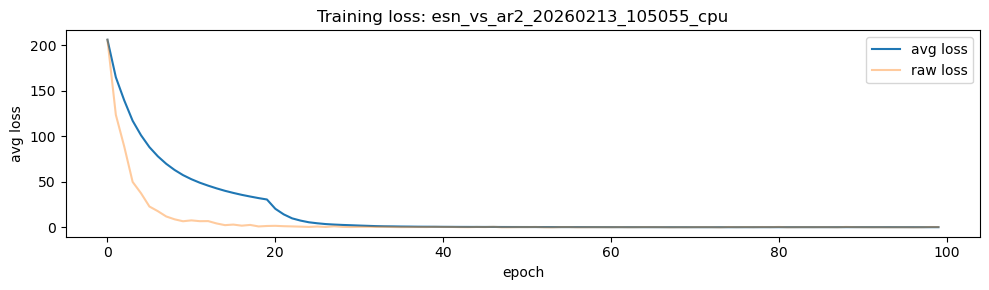

In [27]:
losses = plot_loss_from_run(results, kwargs, overlay_raw=True, log_scale=False, overlay_lr = False, mark_best_and_drops=False)

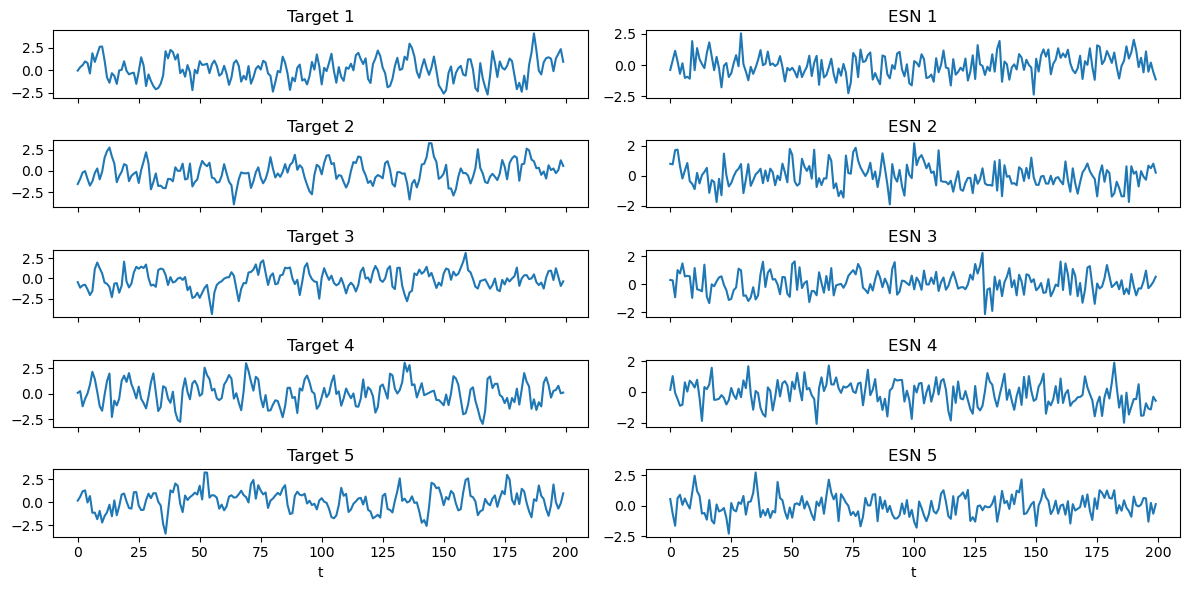

MMD: 0.1402027024887249


In [25]:
inspection = inspect_run_and_mmd(results, kwargs, n_examples=5)   